# 1. Data Loading

In [1]:
import pandas as pd
dataset_df = pd.read_csv('../data/generic_changed_dataset.csv')

In [2]:
dataset_df.head()

,dialogue,labels,type
0,"caller: Hello, good morning. My name is Priya ...",1,Consumer & Retail Scams
1,"caller: Good morning, Madam Lee. My name is Ag...",1,Impersonation Scams
2,"caller: Good morning, Mr. Lim. This is Inspect...",1,Impersonation Scams
3,"caller: Hello, is this Sarah Miller? recipient...",1,Loan & Debt Scams
4,"caller: Hello, is this David Chen? recipient: ...",1,Loan & Debt Scams


In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  2000 non-null   object
 1   labels    2000 non-null   int64 
 2   type      2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [4]:
dataset_df['labels'].value_counts()

labels
1    1000
0    1000
Name: count, dtype: int64

# 2. Explore the data

This process is important as we will need to understand our data before we can further apply machine learning models to it. Some of our key analyses include:

1. Performing EDA separately for the "Caller" and the "Recipient";
2. Identify the differences in language usage between the two roles;
3. Perform data visualization such as **word clouds** to identify frequently used words for both "Caller" and "Recipient";
4. Plot top unigrams, bigrams, and trigrams for each speaker category;
    - Purpose: To gain insights onto conversational patterns
    - Can identify the frequency of scam-specific words/phrases such as "SSN" or "Congratulations" or "Claim Prize"

### Remove Stopwords

In [5]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JunXian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)

In [7]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: Hello, good morning. My name is Priya ...",1,Consumer & Retail Scams,"caller: Hello, good morning. My name Priya 'Ho..."
1,"caller: Good morning, Madam Lee. My name is Ag...",1,Impersonation Scams,"caller: Good morning, Madam Lee. My name Agent..."
2,"caller: Good morning, Mr. Lim. This is Inspect...",1,Impersonation Scams,"caller: Good morning, Mr. Lim. This Inspector ..."
3,"caller: Hello, is this Sarah Miller? recipient...",1,Loan & Debt Scams,"caller: Hello, Sarah Miller? recipient: Yes, s..."
4,"caller: Hello, is this David Chen? recipient: ...",1,Loan & Debt Scams,"caller: Hello, David Chen? recipient: Yes, spe..."


### Separate Caller and Recipient Conversation

In [8]:
import pandas as pd

def extract_caller_and_recipient_texts(dataframe, dialogue_column):
    """
    Extracts texts spoken by 'caller' and 'recipient' from the dialogue column.
    
    Args:
        dataframe (pd.DataFrame): The input dataframe.
        dialogue_column (str): The name of the column with dialogues.
    
    Returns:
        pd.Series, pd.Series: Two Series containing caller and recipient texts.
    """
    caller_texts = []
    recipient_texts = []
    
    for dialogue in dataframe[dialogue_column]:
        # Initialize empty caller and recipient texts
        caller_text = []
        recipient_text = []

        # Split the dialogue into parts based on markers
        parts = dialogue.split("caller:")
        for part in parts[1:]:  # Skip the first split (everything before the first 'caller:')
            if "recipient:" in part:
                # Split between caller and recipient
                caller, recipient = part.split("recipient:", 1)
                caller_text.append(caller.strip())
                recipient_text.append(recipient.strip())
            else:
                # No recipient part, only caller's text
                caller_text.append(part.strip())

        # Append the extracted text to respective lists
        caller_texts.append(" ".join(caller_text))
        recipient_texts.append(" ".join(recipient_text))
    
    # Convert to pandas Series
    return pd.Series(caller_texts, name="caller_texts"), pd.Series(recipient_texts, name="recipient_texts")

In [9]:
caller_texts, recipient_texts = extract_caller_and_recipient_texts(dataset_df, "dialogue")

dataset_df["caller_texts"] = caller_texts
dataset_df["recipient_texts"] = recipient_texts

#### Caller Texts

In [10]:
dataset_df['caller_texts'].head()

0    Hello, good morning. My name is Priya from 'Ho...
1    Good morning, Madam Lee. My name is Agent Tan ...
2    Good morning, Mr. Lim. This is Inspector Wong ...
3    Hello, is this Sarah Miller? Hi Sarah, this is...
4    Hello, is this David Chen? Hi David, my name i...
Name: caller_texts, dtype: object

In [11]:
dataset_df['caller_texts'].tail()

1995    hello, this is jessica from the bank's fraud d...
1996    hello, this is ryan from the bank's fraud depa...
1997    hello, this is olivia from the bank's fraud de...
1998    hello, this is ethan from the bank's fraud dep...
1999    hello, this is lisa from the bank's fraud depa...
Name: caller_texts, dtype: object

#### Recipient Texts

In [12]:
dataset_df['recipient_texts'].head()

0    I'm doing well, thank you. How can I help you?...
1    Yes, speaking. What? That's impossible! I didn...
2    Oh, good morning. A package? What's the proble...
3    Yes, speaking. Oh, really? That sounds great! ...
4    Yes, speaking. That sounds interesting, but I ...
Name: recipient_texts, dtype: object

In [13]:
dataset_df['recipient_texts'].tail()

1995    i wasn't aware of any unauthorized activities....
1996    i wasn't aware of any unauthorized activities....
1997    i wasn't aware of any unauthorized activities....
1998    i wasn't aware of any unauthorized activities....
1999    i wasn't aware of any unauthorized activities....
Name: recipient_texts, dtype: object

### Word Cloud

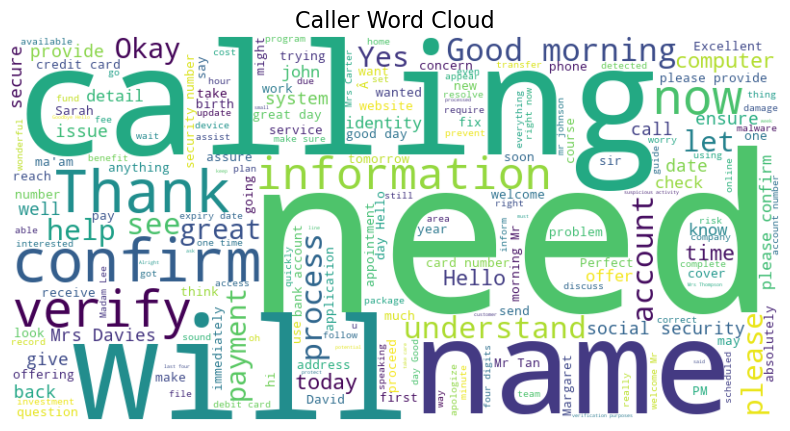

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text_series, title):
    """
    Generates a word cloud from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        title (str): Title of the word cloud visualization.
    """
    text = " ".join(text_series.dropna())  # Combine all text into one string
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

generate_word_cloud(dataset_df["caller_texts"], "Caller Word Cloud")

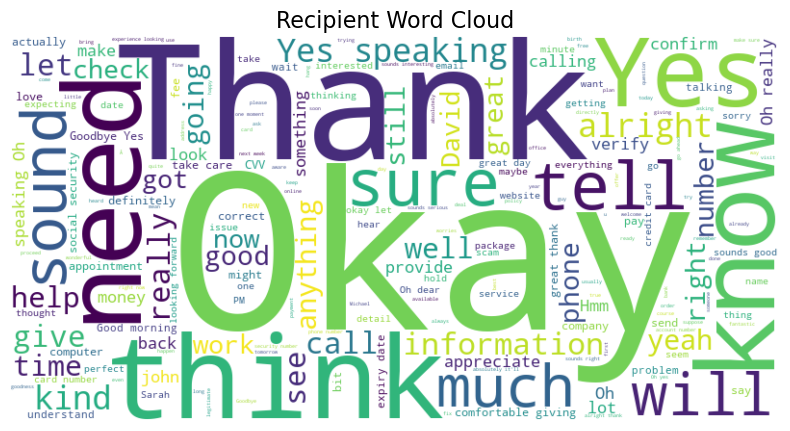

In [15]:
generate_word_cloud(dataset_df["recipient_texts"], "Recipient Word Cloud")

### Most frequently used words for both caller and recipient (Unigram)

The N-gram, is a measure of a sequence of tokens. For example, a 1-gram or unigram is a sequence containing 1 token.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text_series, top_k=10):
    """
    Identifies the most frequently used words in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top words to extract.
    
    Returns:
        List of tuples: Top words and their counts.
    """
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text_series.dropna())
    word_freq = word_counts.sum(axis=0).A1
    word_features = vectorizer.get_feature_names_out()
    top_words = sorted(zip(word_features, word_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_words

In [17]:
import matplotlib.pyplot as plt

def plot_top_words(word_freq, title):
    """
    Plots the top words with their frequencies as a bar chart.
    
    Args:
        word_freq (list of tuples): List of words and their counts.
        title (str): Title of the plot.
    """
    words, counts = zip(*word_freq)  # Unpack words and counts
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color="skyblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Words", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

#### Top Caller Words

In [18]:
top_caller_words = get_top_words(dataset_df["caller_texts"], top_k=10)
print("Top Caller Words:", top_caller_words)

Top Caller Words: [('you', 15369), ('the', 13885), ('to', 13161), ('your', 9263), ('and', 8958), ('we', 8108), ('is', 6733), ('for', 5500), ('it', 5479), ('of', 4707)]


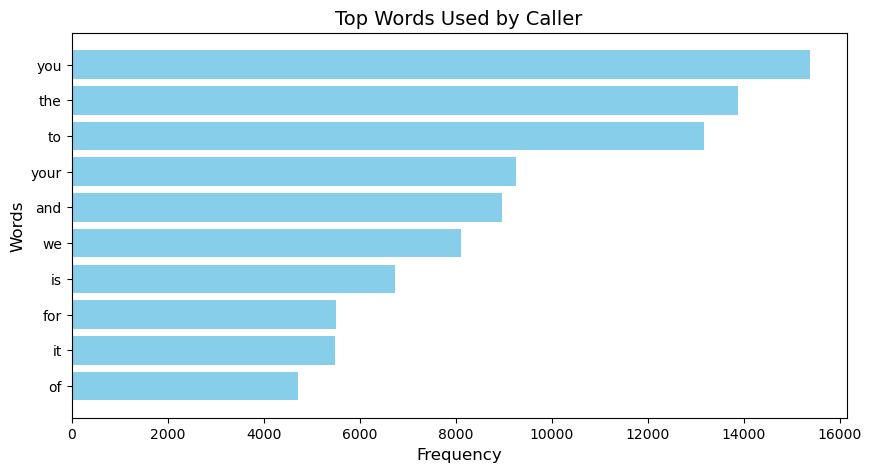

In [19]:
plot_top_words(top_caller_words, "Top Words Used by Caller")

#### Top Recipient Words

In [20]:
top_recipient_words = get_top_words(dataset_df["recipient_texts"], top_k=10)
print("Top Recipient Words:", top_recipient_words)

Top Recipient Words: [('you', 8068), ('the', 5806), ('that', 5157), ('to', 5147), ('it', 4058), ('and', 3025), ('what', 2978), ('for', 2867), ('is', 2780), ('can', 2654)]


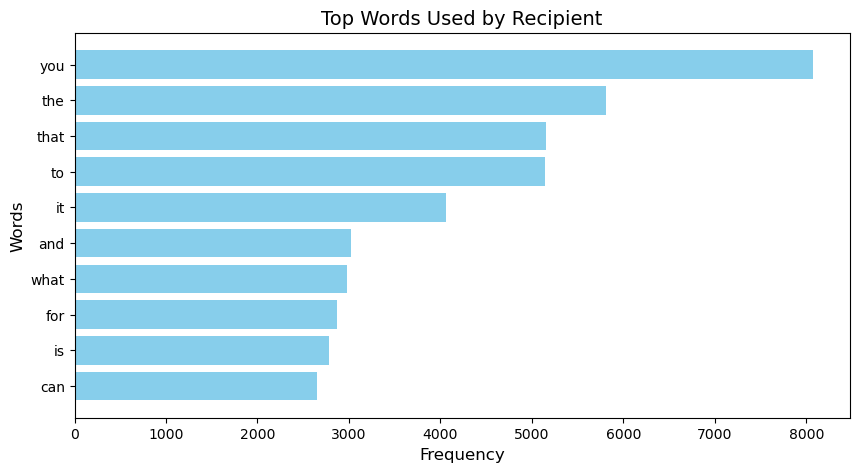

In [21]:
plot_top_words(top_recipient_words, "Top Words Used by Recipient")

### Most frequent bi-grams and tri-grams

This focuses on phrase-level granularity

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to get top n-grams
def get_top_ngrams(text_series, n, top_k=10):
    """
    Identifies the most frequently used n-grams in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        n (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
        top_k (int): Number of top n-grams to extract.
    
    Returns:
        List of tuples: Top n-grams and their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_series.dropna())
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngram_features, ngram_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_ngrams

# Function to plot n-grams
def plot_top_ngrams(ngrams, title):
    """
    Plots the top n-grams with their frequencies as a bar chart.
    
    Args:
        ngrams (list of tuples): List of n-grams and their counts.
        title (str): Title of the plot.
    """
    ngram_labels, ngram_counts = zip(*ngrams)  # Unpack n-grams and counts
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color="lightblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("N-Grams", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

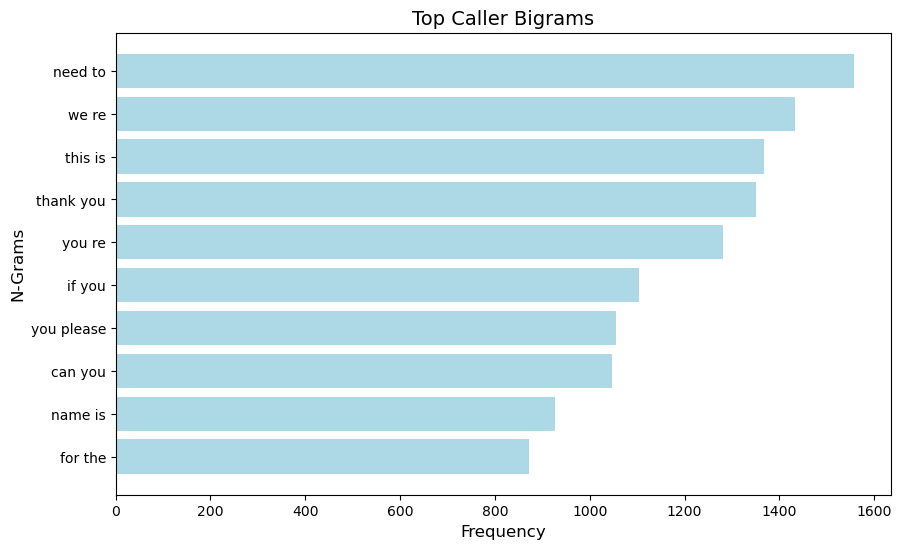

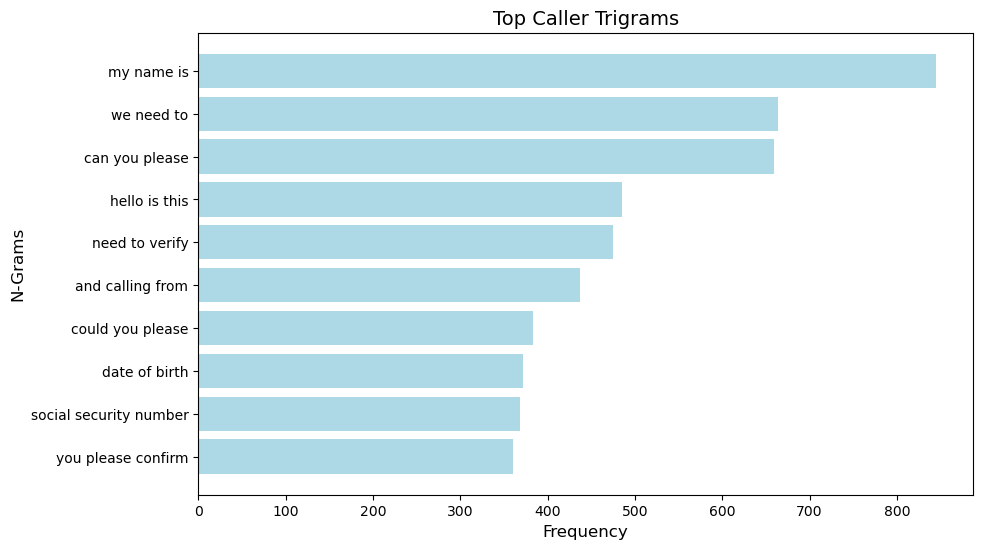

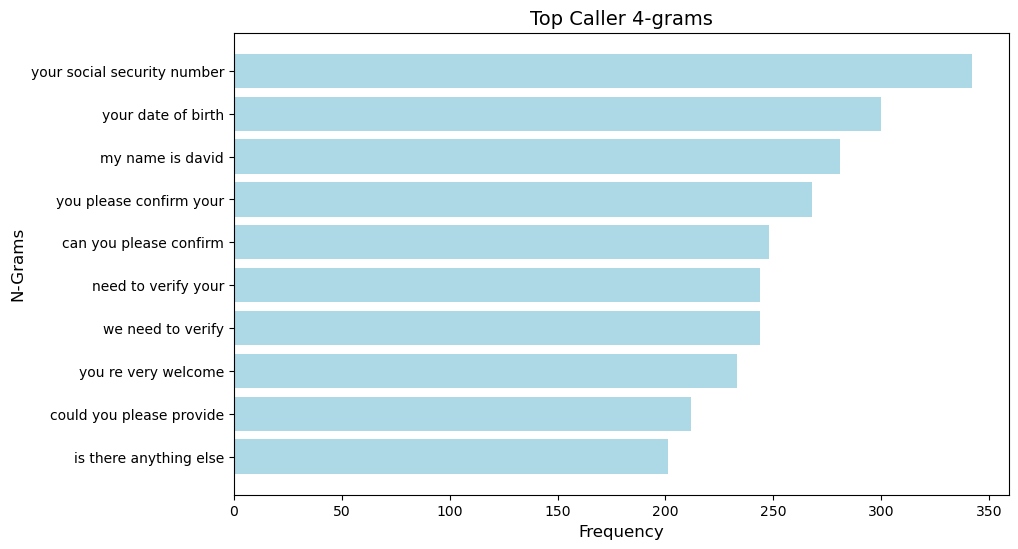

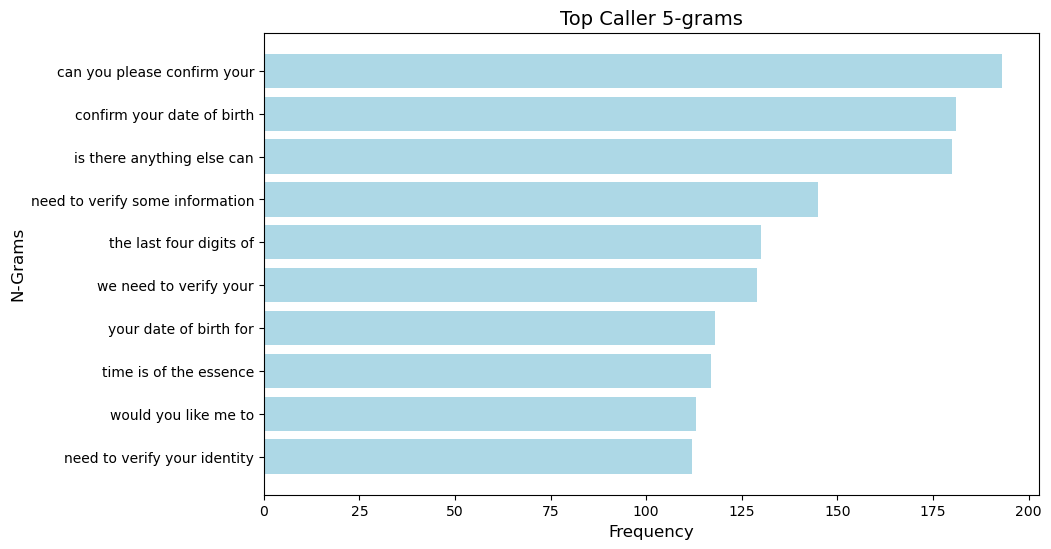

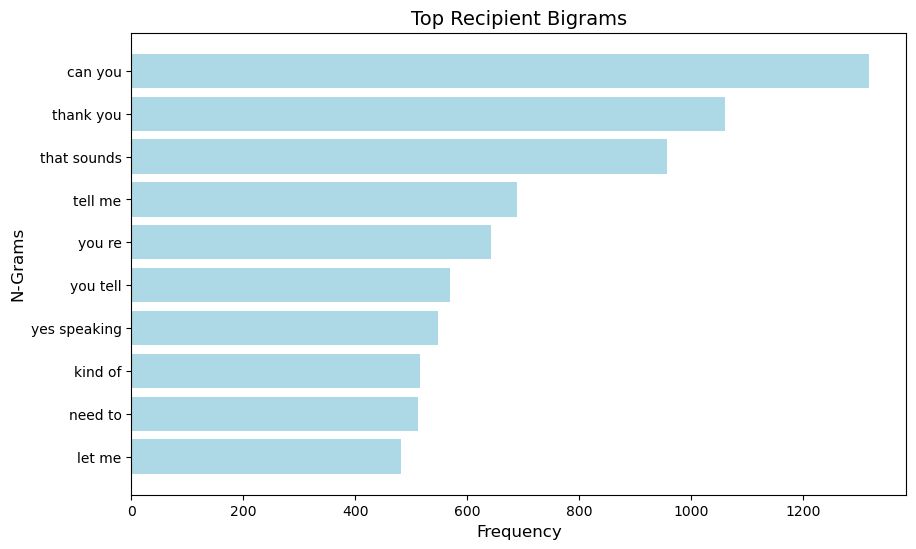

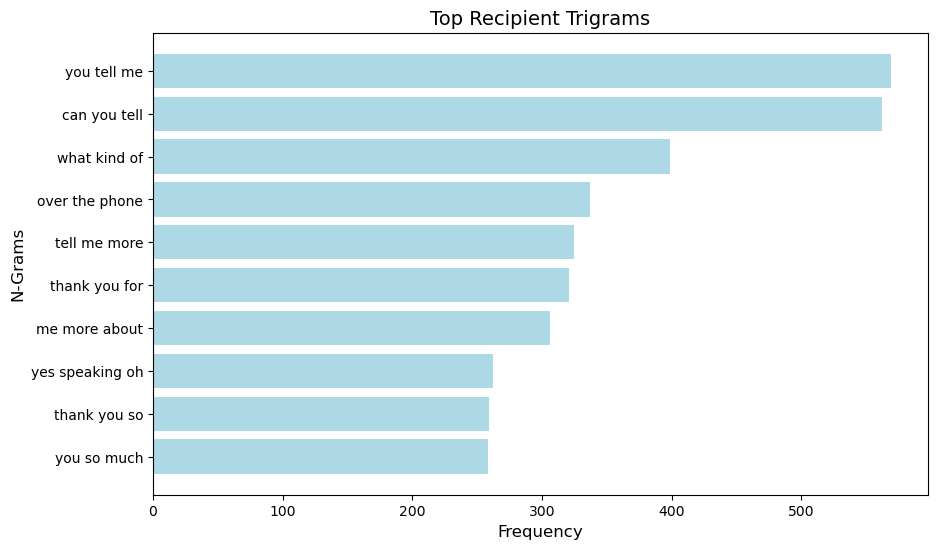

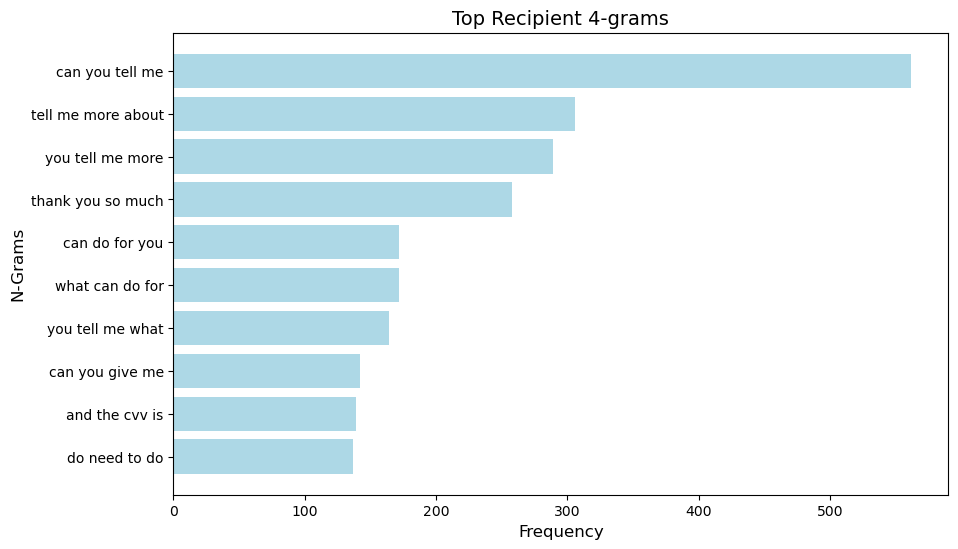

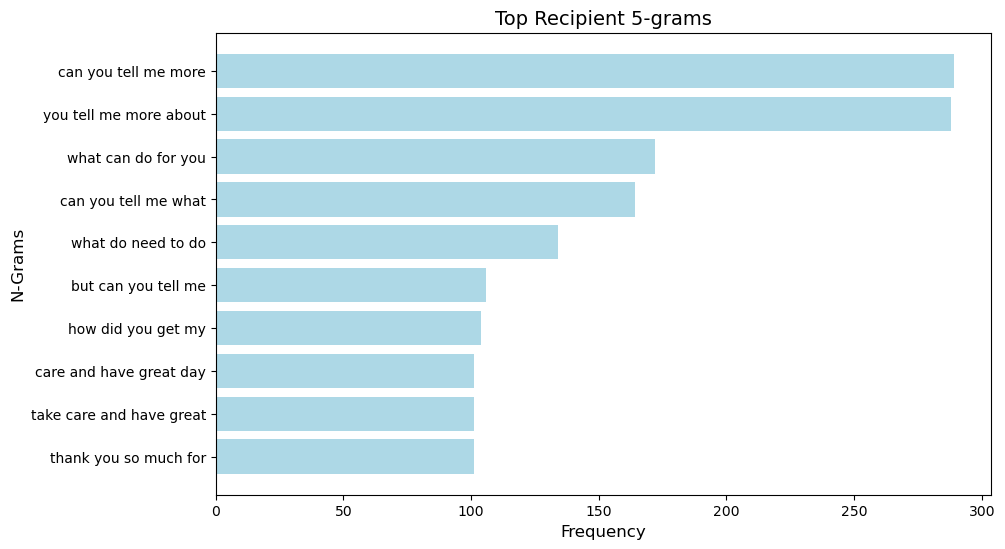

In [23]:
# Replace with your dataset's caller and recipient texts
caller_texts = dataset_df["caller_texts"]  # Ensure this contains the extracted caller texts
recipient_texts = dataset_df["recipient_texts"]  # Ensure this contains the extracted recipient texts

# Generate Bigrams and Trigrams
top_caller_bigrams = get_top_ngrams(caller_texts, n=2, top_k=10)
top_caller_trigrams = get_top_ngrams(caller_texts, n=3, top_k=10)
top_caller_4grams = get_top_ngrams(caller_texts, n=4, top_k=10)
top_caller_pentagrams = get_top_ngrams(caller_texts, n=5, top_k=10)

top_recipient_bigrams = get_top_ngrams(recipient_texts, n=2, top_k=10)
top_recipient_trigrams = get_top_ngrams(recipient_texts, n=3, top_k=10)
top_recipient_4grams = get_top_ngrams(recipient_texts, n=4, top_k=10)
top_recipient_pentagrams = get_top_ngrams(recipient_texts, n=5, top_k=10)
 
# Plot Bigrams and Trigrams for Caller and Recipient
plot_top_ngrams(top_caller_bigrams, "Top Caller Bigrams")
plot_top_ngrams(top_caller_trigrams, "Top Caller Trigrams")
plot_top_ngrams(top_caller_4grams, "Top Caller 4-grams")
plot_top_ngrams(top_caller_pentagrams, "Top Caller 5-grams")
plot_top_ngrams(top_recipient_bigrams, "Top Recipient Bigrams")
plot_top_ngrams(top_recipient_trigrams, "Top Recipient Trigrams")
plot_top_ngrams(top_recipient_4grams, "Top Recipient 4-grams")
plot_top_ngrams(top_recipient_pentagrams, "Top Recipient 5-grams")

### Extract Top Nouns

In [24]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Download SpaCy's English model
spacy.cli.download("en_core_web_sm")

# Enable GPU (if available)
print("GPU Enabled:", spacy.prefer_gpu())

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

def extract_top_nouns(text_series, top_k=10):
    """
    Extracts the top nouns from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top nouns to extract.
    
    Returns:
        List of tuples: Top nouns and their counts.
    """
    all_nouns = []
    
    # Iterate through each text entry
    for text in text_series.dropna():
        doc = nlp(text)  # SpaCy's NLP pipeline
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        all_nouns.extend(nouns)
    
    # Count noun frequencies
    noun_counts = Counter(all_nouns)
    return noun_counts.most_common(top_k)

def plot_top_nouns(noun_counts, title):
    """
    Plots the top nouns with their frequencies as a bar chart.
    
    Args:
        noun_counts (list of tuples): List of nouns and their counts.
        title (str): Title of the plot.
    """
    nouns, counts = zip(*noun_counts)  # Unpack nouns and counts
    plt.figure(figsize=(10, 6))
    plt.barh(nouns, counts, color="coral")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Nouns", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
GPU Enabled: False


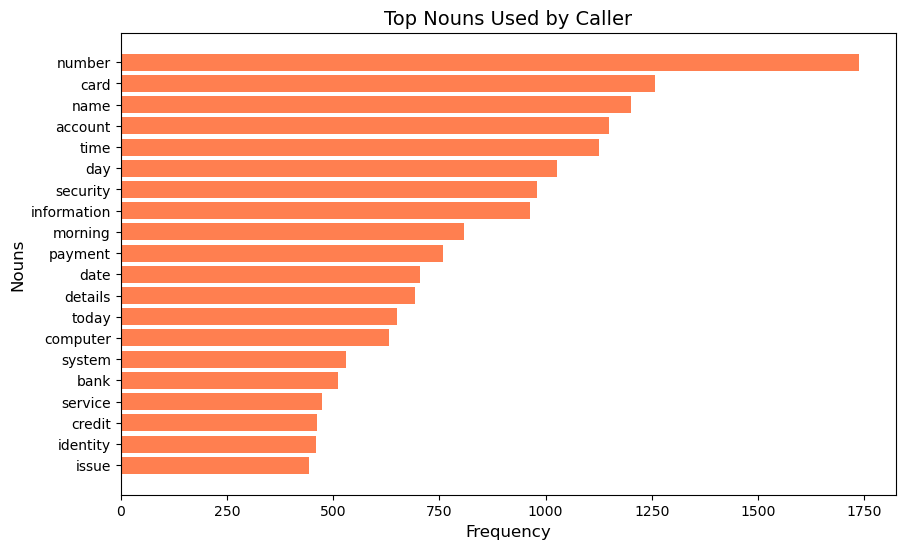

In [25]:
top_caller_nouns = extract_top_nouns(dataset_df["caller_texts"], top_k=20)
plot_top_nouns(top_caller_nouns, "Top Nouns Used by Caller")

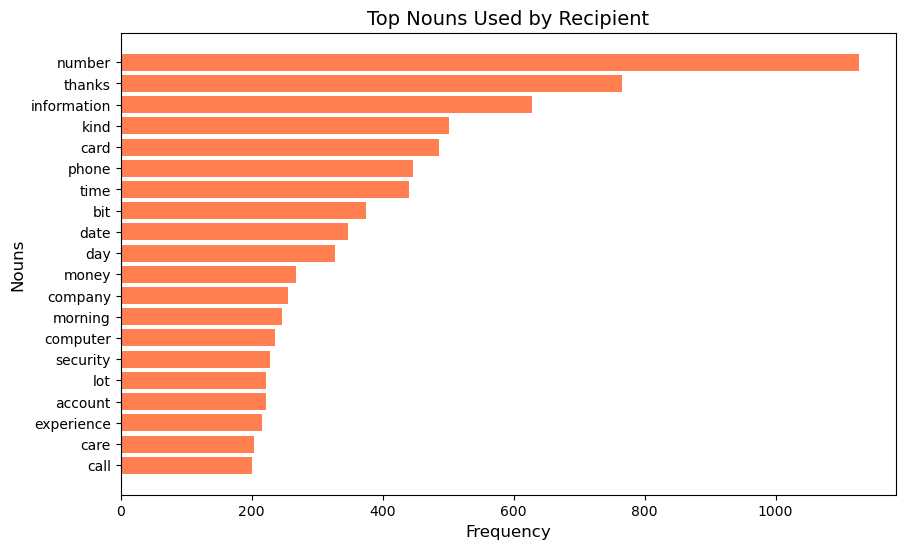

In [26]:
top_recipient_nouns = extract_top_nouns(dataset_df["recipient_texts"], top_k=20)
plot_top_nouns(top_recipient_nouns, "Top Nouns Used by Recipient")

Not much of a difference can be seen between the top nouns used by the caller's and recipients.

#### Recipient's 5-Grams
#### 1. Questions Indicating Clarification or Doubt
- Recipients frequently use phrases like:
  - *"can you tell me more"*
  - *"you tell me more about"*
  - *"how did you get my"*
- These phrases indicate skepticism or curiosity, as recipients often seek clarification or details about the caller's intentions.

#### 2. Focus on Specific Information
- Common phrases include:
  - *"what can do for you"*
  - *"tell me more about the"*
- These patterns suggest that recipients try to gather additional context before making decisions.

#### 3. Skepticism and Inquiry
- Phrases such as:
  - *"how did you get my number"*
  - *"how do know you re"*
- Reflect distrust and a questioning attitude, which are common responses to suspicious calls.

---

#### Caller's 5-Grams
#### 1. Authority and Urgency
- Callers frequently use phrases like:
  - *"can you please confirm your"*
  - *"need to verify some information"*
- These phrases aim to establish authority and create a sense of urgency, aligning with typical scam strategies.

#### 2. Persistence in Communication
- Repeated attempts to contact the recipient are evident in phrases such as:
  - *"we ve been trying to"*
  - *"been trying to reach you"*
- These patterns suggest callers create a narrative of missed communication to pressure recipients into responding.

#### 3. Direct Requests for PII
- Explicit requests for sensitive information are common, as seen in:
  - *"confirm your social security number"*
- These phrases indicate an attempt to extract PII (Personally Identifiable Information), a strong hallmark of scams.

#### 4. Manipulative Language
- Callers use manipulative phrases like:
  - *"time is of the essence"*
- This reflects tactics designed to rush recipients into decisions without careful consideration.

---

#### Comparative Observations
- **Recipient's Behavior**:
  - Recipients focus on clarifying and verifying information.
  - Their responses show skepticism and are inquiry-driven.
- **Caller's Behavior**:
  - Callers use urgency, authority, and persistence to elicit compliance.
  - They frequently make direct requests for sensitive information or actions.

---

#### Conclusion for N-Gram Analysis
- The plots highlight contrasting linguistic strategies:
  - **Recipients**: Seek clarification and express skepticism to protect themselves.
  - **Callers**: Employ authority, urgency, and manipulative language to pressure recipients into compliance.
- These insights can guide feature engineering for the scam detection model, emphasizing linguistic patterns and intent.